In [1]:
!pip install pandas numpy matplotlib scikit-learn tensorflow statsmodels

Epoch 1/100
177/177 - 8s - loss: 0.1173 - 8s/epoch - 46ms/step
Epoch 2/100
177/177 - 5s - loss: 0.1024 - 5s/epoch - 31ms/step
Epoch 3/100
177/177 - 4s - loss: 0.1033 - 4s/epoch - 20ms/step
Epoch 4/100
177/177 - 4s - loss: 0.0947 - 4s/epoch - 20ms/step
Epoch 5/100
177/177 - 5s - loss: 0.0893 - 5s/epoch - 27ms/step
Epoch 6/100
177/177 - 4s - loss: 0.0877 - 4s/epoch - 24ms/step
Epoch 7/100
177/177 - 4s - loss: 0.0850 - 4s/epoch - 20ms/step
Epoch 8/100
177/177 - 4s - loss: 0.0832 - 4s/epoch - 21ms/step
Epoch 9/100
177/177 - 5s - loss: 0.0842 - 5s/epoch - 30ms/step
Epoch 10/100
177/177 - 4s - loss: 0.0816 - 4s/epoch - 21ms/step
Epoch 11/100
177/177 - 4s - loss: 0.0803 - 4s/epoch - 21ms/step
Epoch 12/100
177/177 - 5s - loss: 0.0817 - 5s/epoch - 31ms/step
Epoch 13/100
177/177 - 4s - loss: 0.0837 - 4s/epoch - 21ms/step
Epoch 14/100
177/177 - 4s - loss: 0.0805 - 4s/epoch - 21ms/step
Epoch 15/100
177/177 - 5s - loss: 0.0802 - 5s/epoch - 27ms/step
Epoch 16/100
177/177 - 4s - loss: 0.0821 - 4s/epo

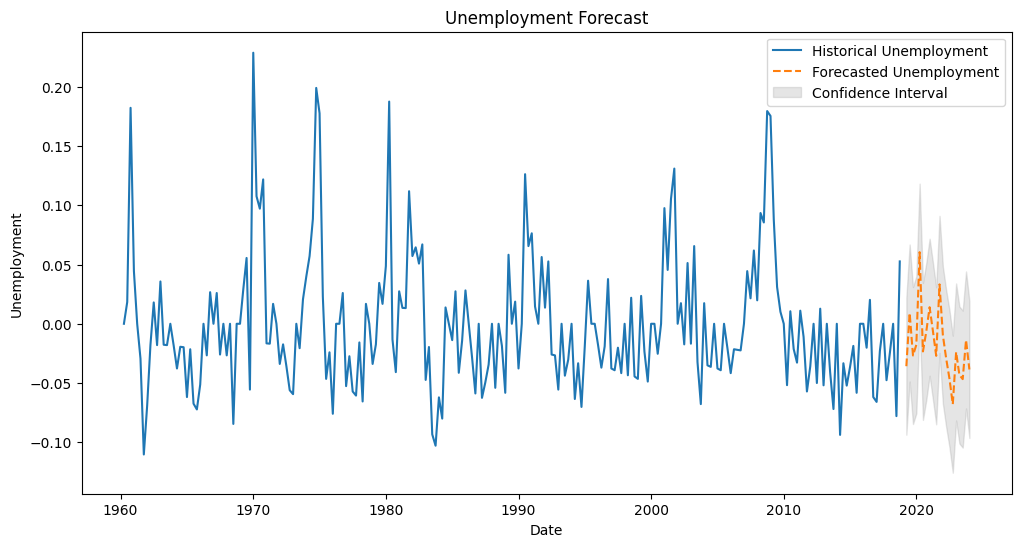


MAE: 0.03396288159149213
MAPE: inf
Theil U: 1.0141013988164131
Bias Proportion: -0.22510499660402009
Variance Proportion: 0.9032318408975296
Covariance Proportion: nan
Symmetric MAPE: 14052.036364559544
RMSE (Test): 0.04150151644838837


<ipython-input-2-8ea4c5396f7f>:157: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100
<ipython-input-2-8ea4c5396f7f>:144: RuntimeWarning: Degrees of freedom <= 0 for slice
  covariance = np.cov(y_true, y_pred)[0, 1]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [2]:
# Importar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Cargar data de CSV proveniente de eViews
data = pd.read_csv('DataDIFLOG2.csv')

# Quitar columnas extras en este caso GDP y inflation
data.drop(columns=['GDP', 'Inflation'], inplace=True)

# Cambiar la columna de "Date" a datetime y poner como indice
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Llenar valores restantes (porsia)
data = data.fillna(method='ffill').fillna(method='bfill')

# Preprocesar la data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(data)

# Dividir la data entre set de entrenamiento y testeo
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Crear los datasets para LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 11  # Actualizado a la longitud de secuencia especificada
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Armar y entrenar el modelo!
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

# Las predicciones!
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invertir predicciones a la escala original
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Asegurarse de que "y_train" y "y_test" sean 2-d antes de la transformacion inversa
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

# Calcular RMSE
train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
print('Train RMSE: %.2f' % (train_rmse))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))
print('Test RMSE: %.2f' % (test_rmse))

# Ahora predecimos los valores futuros
def forecast(model, data, n_steps):
    predictions = []
    current_step = data[-look_back:]
    for _ in range(n_steps):
        current_step = current_step.reshape((1, look_back, 1))
        pred = model.predict(current_step, verbose=0)
        predictions.append(pred[0, 0])
        current_step = np.append(current_step[:, 1:, :], [[pred[0]]], axis=1)
    return np.array(predictions)

# Prediccion desde Q12019 hasta Q42023 (20 trimestres en total)
future_steps = 20
future_forecast = forecast(model, scaled_data, future_steps)

# Invertir la prediccion a escala original
future_forecast = scaler.inverse_transform(future_forecast.reshape(-1, 1))

# Crear rango de datos para futuras predicciones
future_dates = pd.date_range(start='2019-01-01', periods=future_steps, freq='Q')
future_df = pd.DataFrame(future_forecast, index=future_dates, columns=['Unemployment'])

# Print los valores de Unemployment predecidos por trimestre
print("\nForecasted Unemployment per Quarter:")
for date, unemployment in future_df.itertuples():
    print(f"{date}: {unemployment}")

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(data, label='Historical Unemployment')
plt.plot(future_df, label='Forecasted Unemployment', linestyle='--')

# Calcular el error estandar para hacer el intervalo de confianza
predictions_std = np.std(future_forecast)
conf_int_upper = future_forecast.flatten() + 2 * predictions_std
conf_int_lower = future_forecast.flatten() - 2 * predictions_std

# Confidence interval (2 standard errors)
plt.fill_between(future_df.index, conf_int_lower, conf_int_upper, color='gray', alpha=0.2, label='Confidence Interval')

plt.title('Unemployment Forecast')
plt.xlabel('Date')
plt.ylabel('Unemployment')
plt.legend()
plt.show()

# Aca hacemos las pruebas
def theil_u(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.sum((y_pred - y_true)**2) / np.sum(y_true**2))

def bias_proportion(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(y_pred - y_true) / np.mean(y_true)

def variance_proportion(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.var(y_pred) / np.var(y_true)

def covariance_proportion(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if len(y_true) < 2 or len(y_pred) < 2:
        return np.nan
    covariance = np.cov(y_true, y_pred)[0, 1]
    std_true = np.std(y_true)
    std_pred = np.std(y_pred)
    if std_true == 0 or std_pred == 0:
        return np.nan
    return covariance / (std_true * std_pred)

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = np.abs(y_true) + np.abs(y_pred)
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / denominator[denominator != 0])

mae = mean_absolute_error(y_test, test_predict)
mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100
theil_u_stat = theil_u(y_test, test_predict)
bias = bias_proportion(y_test, test_predict)
variance = variance_proportion(y_test, test_predict)
covariance = covariance_proportion(y_test, test_predict)
smape_value = smape(y_test, test_predict)

print(f'\nMAE: {mae}')
print(f'MAPE: {mape}')
print(f'Theil U: {theil_u_stat}')
print(f'Bias Proportion: {bias}')
print(f'Variance Proportion: {variance}')
print(f'Covariance Proportion: {covariance}')
print(f'Symmetric MAPE: {smape_value}')
print(f'RMSE (Test): {test_rmse}')

In [ ]:
def theil_u(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.sum((y_pred - y_true)**2) / np.sum(y_true**2))

def bias_proportion(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(y_pred - y_true) / np.mean(y_true)

def variance_proportion(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.var(y_pred) / np.var(y_true)

def covariance_proportion(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if len(y_true) < 2 or len(y_pred) < 2:
        return np.nan
    covariance = np.cov(y_true, y_pred)[0, 1]
    std_true = np.std(y_true)
    std_pred = np.std(y_pred)
    if std_true == 0 or std_pred == 0:
        return np.nan
    return covariance / (std_true * std_pred)

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = np.abs(y_true) + np.abs(y_pred)
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / denominator[denominator != 0])

mae = mean_absolute_error(y_test, test_predict)
mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100
theil_u_stat = theil_u(y_test, test_predict)
bias = bias_proportion(y_test, test_predict)
variance = variance_proportion(y_test, test_predict)
covariance = covariance_proportion(y_test, test_predict)
smape_value = smape(y_test, test_predict)

print(f'\nMAE: {mae}')
print(f'MAPE: {mape}')
print(f'Theil U: {theil_u_stat}')
print(f'Bias Proportion: {bias}')
print(f'Variance Proportion: {variance}')
print(f'Covariance Proportion: {covariance}')
print(f'Symmetric MAPE: {smape_value}')
print(f'RMSE (Test): {test_rmse}')


MAE: 0.030701801598903955
MAPE: inf
Theil U: 0.902601516581367
Bias Proportion: -0.3452888536383013
Variance Proportion: 0.4136728671919022
Covariance Proportion: nan
Symmetric MAPE: 6139.978192034022
RMSE (Test): 0.036640835790145036


<ipython-input-3-a9fe3c502c17>:30: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100
<ipython-input-3-a9fe3c502c17>:17: RuntimeWarning: Degrees of freedom <= 0 for slice
  covariance = np.cov(y_true, y_pred)[0, 1]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
